https://www.kaggle.com/competitions/playground-series-s3e17 

****In progress.


In [1]:
import pandas as pd
import copy
import numpy as np

from scipy.optimize import minimize

from sklearn.metrics import ( 
    f1_score,
    roc_auc_score,
    mean_squared_error
    )
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold


from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import optuna

In [2]:
PATH = '/kaggle/input/playground-series-s3e17/'
PATH_orign = '/kaggle/input/machine-failure-predictions/'
#/kaggle/input/playground-series-s3e17/train.csv
RANDOM_SEED = 777

# Data loading and analysis

In [4]:
df = pd.read_csv(f'{PATH}train.csv')
new_columns = {
    'Air temperature [K]': 'air_temperature',
    'Process temperature [K]': 'proc_temperature',
    'Rotational speed [rpm]': 'rot_speed',
    'Torque [Nm]': 'torque',
    'Tool wear [min]': 'tool_wear'
}
df = df.rename(columns=new_columns)
df_origin = pd.read_csv(f"{PATH_orign}machine failure.csv")
df_origin = df_origin.rename(columns=new_columns)
df_origin = df_origin.drop('UDI',axis=1)

df = df.drop(['id'], axis = 1)
df = pd.concat([df, df_origin], ignore_index=True)
df = df.drop_duplicates()
# shufle
df = df.sample(frac=1).reset_index(drop=True)
#df = df.reset_index(drop=True)

df_test = pd.read_csv(f'{PATH}test.csv')
df_test = df_test.drop(['id'], axis = 1)
df_test = df_test.rename(columns=new_columns)

df_submisson = pd.read_csv(f'{PATH}sample_submission.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145295 entries, 0 to 145294
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Product ID        145295 non-null  object 
 1   Type              145295 non-null  object 
 2   air_temperature   145295 non-null  float64
 3   proc_temperature  145295 non-null  float64
 4   rot_speed         145295 non-null  int64  
 5   torque            145295 non-null  float64
 6   tool_wear         145295 non-null  int64  
 7   Machine failure   145295 non-null  int64  
 8   TWF               145295 non-null  int64  
 9   HDF               145295 non-null  int64  
 10  PWF               145295 non-null  int64  
 11  OSF               145295 non-null  int64  
 12  RNF               145295 non-null  int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 14.4+ MB


In [6]:
df['Product ID'].nunique()

10000

In [7]:
df['Type'].unique()

array(['L', 'M', 'H'], dtype=object)

<Axes: >

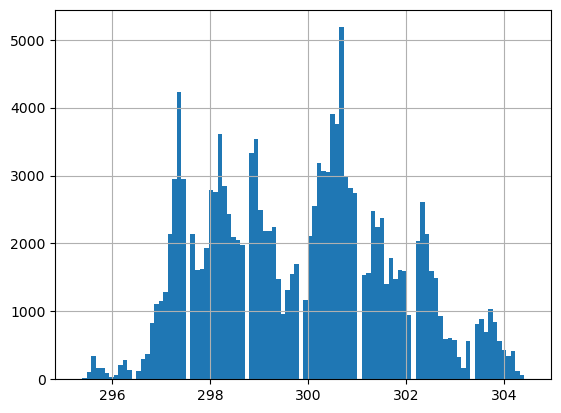

In [8]:
df['air_temperature'].hist(bins=100)

<Axes: >

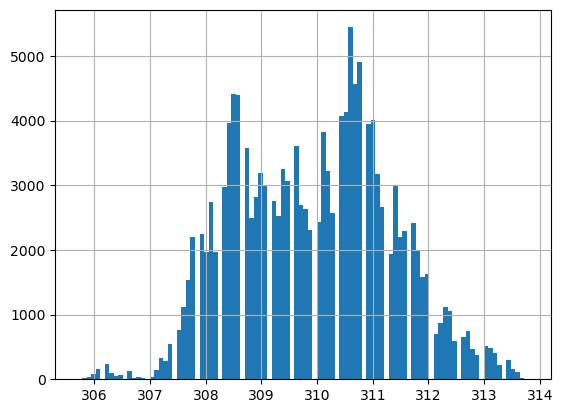

In [10]:
df['proc_temperature'].hist(bins=100)

<Axes: >

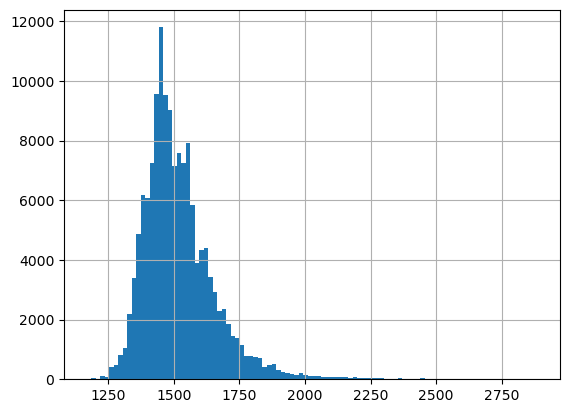

In [11]:
df['rot_speed'].hist(bins=100)

we can see outliers. and we can cat them  if need.

In [12]:
df['rot_speed'].describe()

count    145295.000000
mean       1521.608238
std         141.890181
min        1168.000000
25%        1432.000000
50%        1494.000000
75%        1583.000000
max        2886.000000
Name: rot_speed, dtype: float64

<Axes: >

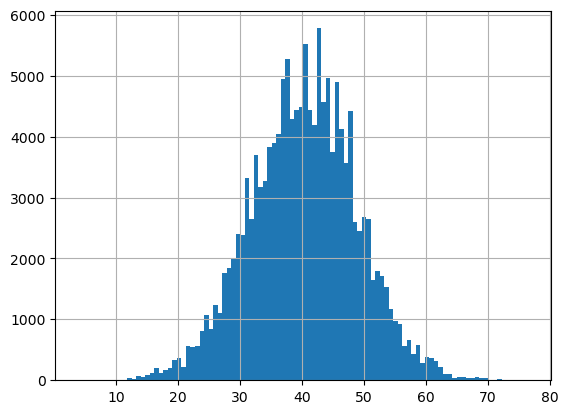

In [13]:
df['torque'].hist(bins=100)


<Axes: >

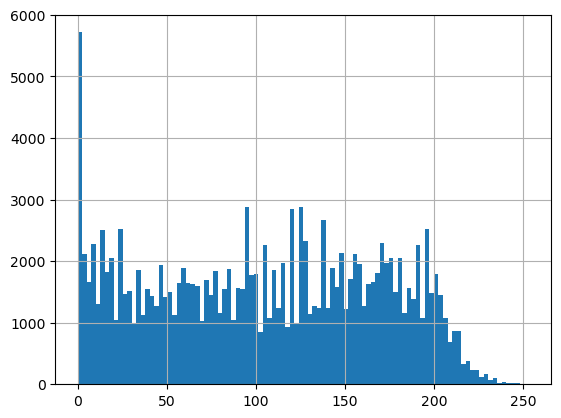

In [14]:
df['tool_wear'].hist(bins=100)


In [15]:
df['Machine failure'].mean()

0.016986131663168036

we can see hard class disbalance, only 1.69% for 1 class.   
we need use upsumpling and other class balans strategy

In [16]:
df['TWF'].mean()

0.0017481675212498709

In [17]:
df['HDF'].mean()

0.005616160225747617

In [18]:
df['PWF'].mean()

0.0028562579579476236

In [19]:
df['OSF'].mean()

0.00434288860593964

In [20]:
df['RNF'].mean()

0.0022368285212842837

In [21]:
df[df['Machine failure'] == 1]

,Product ID,Type,air_temperature,proc_temperature,rot_speed,torque,tool_wear,Machine failure,TWF,HDF,PWF,OSF,RNF
1,L49682,L,299.2,309.0,1467,48.8,228,1,0,0,0,1,0
98,M20857,M,300.5,310.2,1387,53.2,228,1,0,0,0,1,0
142,M19269,M,302.4,310.1,1372,47.8,61,1,0,1,0,0,0
146,L51465,L,301.7,309.9,1317,49.1,2,1,0,1,0,0,0
173,L51649,L,302.7,310.4,1454,51.2,211,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
145049,L51563,L,301.7,309.5,1298,65.5,229,1,0,1,0,0,0
145208,L56673,L,299.1,309.9,1398,55.4,217,1,0,0,0,0,0
145211,L51577,L,302.4,310.2,1379,53.4,94,1,0,1,0,0,0
145229,L51586,L,301.9,310.3,1326,58.5,55,1,0,1,0,0,0


# ML search for hyperparameters for models

## functions for transform dataset

In [4]:
#cat
cat_features = ['Product ID']
def cat_features_transform(df):
    X = df.drop( ["RNF","Type",], axis=1 )
    X['air_proc_temp'] = X['proc_temperature'] - X['air_temperature']
    
    return X

#cat mass features

def cat_mass_features_transform(df):
     X = copy.deepcopy(df)#.drop( ["RNF","Type",], axis=1 )
     X['air_proc_temp'] = X['proc_temperature'] - X['air_temperature']
     X['1'] = X['tool_wear']  / X['torque']
     #X['Product ID'] = X['Product ID'].map(lambda x:x[1:]).astype(int)
     
     return X
    

#lgbm
def lgbm_features_transform(df):
    X = df.drop(["RNF",'Type' ], axis=1)
    cat_cols = ['Product ID',]#'TWF','HDF','PWF','OSF',,'Type'
    X[cat_cols] = X[cat_cols].astype('category')
    return X

#xgbm
def xgb_features_transform(df):
    X = df.drop(['RNF','Type'], axis=1)
    cat_cols = [ 'Product ID' ]#'TWF', 'HDF', 'PWF', 'OSF',
    X[cat_cols] = X[cat_cols].astype('category')
    return X


params_cat = {'colsample_bylevel': 0.08626457273071049, 'depth': 11, 'bootstrap_type': 'Bernoulli', 'subsample': 0.3279247373279072, 'learning_rate': 0.04403515413343487, 'l2_leaf_reg': 5.063801984506869, 'random_strength': 6.236587532391947} 
params_lgbm = {'colsample_bytree': 0.06498125049638995, 'learning_rate': 0.021348599497712315, 'max_depth': 14, 'min_child_samples': 152, 'n_estimators': 525, 'num_leaves': 20, 'subsample': 0.2593894206734538}
params_xgb =   {'booster': 'gbtree', 'lambda': 1.1950782767177348e-06, 'alpha': 7.422417494928901e-08, 'subsample': 0.8979427074015565, 'colsample_bytree': 0.27903534961193494, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.01938432249917246, 'gamma': 1.366693055441344e-07, 'grow_policy': 'lossguide'}

## Catboost

In [ ]:
%%time

X = cat_features_transform(df).drop('Machine failure',axis=1)
y = df['Machine failure']
cat_features = X.select_dtypes(include='object').columns.to_list()
#9791
#params_cat = {'objective': 'Logloss', 'colsample_bylevel': 0.0903896308781284, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.24621984576312345}

#9806
params_cat = {'colsample_bylevel': 0.08626457273071049, 'depth': 11, 'bootstrap_type': 'Bernoulli', 'subsample': 0.3279247373279072, 'learning_rate': 0.04403515413343487, 'l2_leaf_reg': 5.063801984506869, 'random_strength': 6.236587532391947} 

#model = CatBoostClassifier(cat_features=cat_features,verbose=False, )
#model = CatBoostClassifier(cat_features=cat_features,verbose=False,task_type='GPU')  eval_metric='AUC' ,task_type='GPU'

model = CatBoostClassifier(cat_features=cat_features,verbose=False,**params_cat, ) 

scores = cross_val_score(model, X, y, cv=4,scoring='roc_auc' )
scores.mean()

все фичи(кропе Type 0.9633336494512796   
drop("RNF" 0.9632721976060314    
Type + drop(RNF 0.9630476791087349    
X = X.drop(["RNF","Type"],axis=1)   0.9634064812194127   
'Product ID'    и дефолт ....0.9746626706218604    
Добавлена sum как число 0.974041265412260 б как кат 0.9739394099232173, она затеняет все эти TWF   
df['air_proc_temp'] = df['proc_temperature'] - df['air_temperature']   0.9751679193553163  
eval_metric='AUC' не улушает метрику      
 power  default+gpu 0.9752411456599929   
 params_cat 0.975386357835057    
 **param and all_df 0.9804687830876277       
 0.9791534786916188  eval_metric='AUC' )  тоже самое без метрики




In [51]:
%%time

X = cat_mass_features_transform(df).drop('Machine failure',axis=1)
y = df['Machine failure']
cat_features = X.select_dtypes(include='object').columns.to_list()
model = CatBoostClassifier(cat_features=cat_features,verbose=False)
#model = CatBoostClassifier(cat_features=cat_features,verbose=False,task_type='GPU',iterations=10000,  learning_rate=0.1, early_stopping_rounds=200 ) 
scores = cross_val_score(model, X, y, cv=4,scoring='roc_auc' )
scores.mean()

CPU times: user 17min 13s, sys: 44.3 s, total: 17min 57s
Wall time: 4min 51s


0.9800291585642783

 
все mass фичи 0.9800291585642783  vs cat(см фукцию первую) 0.9791534786916188


In [82]:

model.fit(X,y)
feature_importances_cat = pd.Series(model.feature_importances_, index=model.feature_names_).sort_values(ascending=False)
feature_importances_cat

rot_speed           13.206319
Product ID          12.214759
tool_wear           11.835001
HDF                 11.828690
torque               9.342593
OSF                  8.176630
power                7.291559
air_proc_temp        6.454041
air_temperature      6.087643
proc_temperature     5.460630
TWF                  4.057641
PWF                  4.044494
dtype: float64

In [ ]:
X = cat_features_transform(df).drop('Machine failure',axis=1)
y = df['Machine failure']
cat_features = ['TWF','HDF','PWF','OSF','Product ID']

#  GridSearch
params = {'learning_rate': [0.05,0.07,0.1],'objective': 'Logloss', 'colsample_bylevel': 0.0903896308781284, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.24621984576312345}
   # 'learning_rate': [0.05],
   # 'max_depth': [5,6,7,8]}
  # 'n_estimators': [120, 130, 140],
   # 'num_leaves': [9, 10, 11]}

model = CatBoostClassifier(cat_features=cat_features,verbose=False ) #,task_type='GPU'
grid_search = GridSearchCV(model, params, scoring='roc_auc', cv=3)
grid_search.fit(X, y)

# 
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Best Parameters:  {'learning_rate': 0.05, 'max_depth': 5}
Best Score:  0.9748571442209211

In [50]:
X = cat_features_transform(df).drop('Machine failure',axis=1)
y = df['Machine failure']

def objective(trial):
    param = {
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', max(params_cat['colsample_bylevel']-0.1, 0), params_cat['colsample_bylevel']+0.1),
        'depth': trial.suggest_int('depth', max(params_cat['depth']-2, 1), params_cat['depth']+2),
        'bootstrap_type': trial.suggest_categorical('bootstrap_type', [ 'Bernoulli']),
        'subsample': trial.suggest_float('subsample', max(params_cat['subsample']-0.1, 0), params_cat['subsample']+0.1),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10),
        'random_strength': trial.suggest_float('random_strength', 0.1, 10)
    }
    
    model = CatBoostClassifier(cat_features=cat_features,verbose=False,**param)
        #model.fit(X, y, verbose=False)
   
  
    scores = cross_val_score(model, X, y, cv=3, scoring='roc_auc')
    
    return scores.mean()


# Создание и запуск оптимизации Optuna
#optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, timeout=1200)

# Вывод результатов
print('Best trial:', study.best_trial.params)
print('Best roc_auc:', study.best_value)

[I 2023-06-20 16:45:58,812] A new study created in memory with name: no-name-3e2109b6-3515-49f5-b95b-a17fa2a52dbd
[I 2023-06-20 16:47:08,072] Trial 0 finished with value: 0.9788221220574901 and parameters: {'colsample_bylevel': 0.04460396261602394, 'depth': 9, 'bootstrap_type': 'Bernoulli', 'subsample': 0.37299953363532956, 'learning_rate': 0.06352274471623542, 'l2_leaf_reg': 3.8405493023927204, 'random_strength': 1.0664433381606098}. Best is trial 0 with value: 0.9788221220574901.
[I 2023-06-20 16:52:23,452] Trial 1 finished with value: 0.9738433296164706 and parameters: {'colsample_bylevel': 0.18180216331939159, 'depth': 13, 'bootstrap_type': 'Bernoulli', 'subsample': 0.2871182780398679, 'learning_rate': 0.0498230869051525, 'l2_leaf_reg': 0.8375241739274603, 'random_strength': 7.9030653107990885}. Best is trial 0 with value: 0.9788221220574901.
[I 2023-06-20 16:53:30,543] Trial 2 finished with value: 0.9784714379820866 and parameters: {'colsample_bylevel': 0.044969464072945324, 'dept

Best trial: {'colsample_bylevel': 0.1310935256512804, 'depth': 10, 'bootstrap_type': 'Bernoulli', 'subsample': 0.2903374465936198, 'learning_rate': 0.02785680483905257, 'l2_leaf_reg': 7.40799322758401, 'random_strength': 6.086274113889851}
Best roc_auc: 0.9797636796564412


Best trial: {'objective': 'Logloss', 'colsample_bylevel': 0.0903896308781284, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.24621984576312345}
Best roc_auc: 0.9749624911023128              
Best trial: {'learning_rate': 0.04506512862158424, 'objective': 'Logloss', 'colsample_bylevel': 0.09365840173615486, 'depth': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.0980083409784012}
Best roc_auc: 0.9749888976321884     

Best trial: {'colsample_bylevel': 0.08626457273071049, 'depth': 11, 'bootstrap_type': 'Bernoulli', 'subsample': 0.3279247373279072, 'learning_rate': 0.04403515413343487, 'l2_leaf_reg': 5.063801984506869, 'random_strength': 6.236587532391947}
Best roc_auc: 0.9798307177258737



## Light-GBM

In [81]:
#9788
lgb_optuna1 = {
            'num_iterations': 200,
            'learning_rate': 0.024714536811915398,
            'max_depth': 9,
            'lambda': 9.498413255934212,
            'alpha': 7.627590925937886,
            'subsample': 0.9680186598781285,
            'colsample_bytree': 0.5645599877042381,
            'min_child_weight': 1,
            
}
#9761
lgb_optuna2 = {
            'num_iterations': 950,
            'learning_rate': 0.012019976156417951,
            'max_depth': 4,
            'lambda': 6.958643473661789,
            'alpha': 0.0012598800466591953, 
            'subsample': 0.9344619448867001,
            'colsample_bytree': 0.9864399750557648, 
            'min_child_weight': 1,
}

In [83]:
%%time
X = lgbm_features_transform(df).drop('Machine failure',axis=1)
y = df['Machine failure']

#9730
#params_lgbm = {'lambda_l1': 9.055534661103389,  'num_leaves': 199, 'feature_fraction': 0.9936016134327899,   'min_child_samples': 99} 

#9797
#params_lgbm = {'colsample_bytree': 0.3757317950863219, 'learning_rate': 0.010742214082528663, 'max_depth': 8, 'min_child_samples': 23, 'n_estimators': 508, 'num_leaves': 16, 'subsample': 0.8681278451259432}

#9754
#params_lgbm = {'colsample_bytree': 0.11374499269807074, 'learning_rate': 0.04263726332064176, 'max_depth': 9, 'min_child_samples': 131, 'n_estimators': 547, 'num_leaves': 14, 'subsample': 0.3651535894141327}

#0.9757
#params_lgbm =  {'colsample_bytree': 0.09190885235112034, 'learning_rate': 0.04575174317636667, 'max_depth': 11, 'min_child_samples': 127, 'n_estimators': 448, 'num_leaves': 12, 'subsample': 0.308852185825488}

#0.975889  выкинул Type 97526
#params_lgbm = {'colsample_bytree': 0.056796971300652345, 'learning_rate': 0.0481109943378208, 'max_depth': 13, 'min_child_samples': 122, 'n_estimators': 485, 'num_leaves': 15, 'subsample': 0.38147469290079017}

#0.9807
#params_lgbm = {'colsample_bytree': 0.14665991058710195, 'learning_rate': 0.030554224375422046, 'max_depth': 12, 'min_child_samples': 138, 'n_estimators': 531, 'num_leaves': 15, 'subsample': 0.33305946662994906}

#9805
params_lgbm = {'colsample_bytree': 0.06498125049638995, 'learning_rate': 0.021348599497712315, 'max_depth': 14, 'min_child_samples': 152, 'n_estimators': 525, 'num_leaves': 20, 'subsample': 0.2593894206734538}
model = LGBMClassifier(**params_lgbm,  )
scores = cross_val_score(model, X, y, cv=4,scoring='roc_auc' )
scores.mean()

CPU times: user 29.2 s, sys: 180 ms, total: 29.4 s
Wall time: 15.1 s


0.9805403354081907

Все фичи тут : 0.9622412405082026   
drop("RNF" 0.9629947046169225         
.drop(["RNF","OSF","PWF",'HDF' ]   0.9478674673528694       
оставил Type  0.9631988479216044    
оставил Type + drop RNF  0.9641540237044791   BEST    
предыдущее с гипер параметрами подобранными 0.9649689337967341  'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 200, 'num_leaves': 26    
тоже что вверху, но оставил Product ID 0.9682690309692119    
дефолт гипер параметры  0.9693834406668822     
Product ID ваще главный фич теперь в Lgbm...   
{'learning_rate': 0.05,   'max_depth': 5  0.971122899414862  
sum ухудшает слегка метрику   
power 0.9718050857637697       
power + params 0.9744313933885667
params 0.974461804006554

In [187]:
model.fit(X,y)
feature_importances_lgmb = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
feature_importances_lgmb

proc_temperature    228
torque              203
air_temperature     114
tool_wear            78
Type                 77
rot_speed            60
Product ID           46
TWF                  42
PWF                  36
OSF                  29
HDF                   8
dtype: int32

Best Parameters:  {'learning_rate': 0.05, 'max_depth': 5}

Best Parameters:  {'colsample_bytree': 0.2, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_samples': 100, 'n_estimators': 130, 'num_leaves': 10, 'reg_alpha': 0.5, 'reg_lambda': 0.5, 'subsample': 0.1}
Best Score:  0.9744313933885667       
Best Parameters:  {'colsample_bytree': 0.15, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_samples': 100, 'n_estimators': 130, 'num_leaves': 10, 'reg_alpha': 0.5, 'reg_lambda': 0.5, 'subsample': 0.05}
Best Score:  0.9744313933885667
Best Parameters:  {'colsample_bytree': 0.15, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_samples': 100, 'n_estimators': 130, 'num_leaves': 10, 'reg_alpha': 0.5, 'reg_lambda': 0.5, 'subsample': 0.01}
Best Score:  0.9744313933885667


In [ ]:
X = lgbm_features_transform(df).drop('Machine failure',axis=1)
y = df['Machine failure']

def objective(trial):
    # Параметры, которые будут оптимизированы
    param = {
        'colsample_bytree': trial.suggest_float('colsample_bytree', max(params_lgbm['colsample_bytree']-0.1, 0), params_lgbm['colsample_bytree']+0.1),
        'learning_rate': trial.suggest_float('learning_rate', max(params_lgbm['learning_rate']-0.1, 0), params_lgbm['learning_rate']+0.1),
        'max_depth': trial.suggest_int('max_depth', max(params_lgbm['max_depth']-2, 1), params_lgbm['max_depth']+2),
        'min_child_samples': trial.suggest_int('min_child_samples', max(params_lgbm['min_child_samples']-50, 1), params_lgbm['min_child_samples']+50),
        'n_estimators': trial.suggest_int('n_estimators', max(params_lgbm['n_estimators']-100, 1), params_lgbm['n_estimators']+100),
        'num_leaves': trial.suggest_int('num_leaves', max(params_lgbm['num_leaves']-5, 1), params_lgbm['num_leaves']+5),
        'subsample': trial.suggest_float('subsample', max(params_lgbm['subsample']-0.1, 0), params_lgbm['subsample']+0.1)
    }
    model = LGBMClassifier(**param)
    #
    scores = cross_val_score(model, X, y, cv=4, scoring='roc_auc')
    
    return scores.mean()


#optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, timeout=1200)

# Вывод результатов
print('Best trial:', study.best_trial.params)
print('Best roc_auc:', study.best_value)

Best trial: {'lambda_l1': 9.055534661103389, 'lambda_l2': 4.0654162966285554e-05, 'num_leaves': 199, 'feature_fraction': 0.9936016134327899, 'bagging_fraction': 0.6358784506047733, 'bagging_freq': 7, 'min_child_samples': 99}
Best roc_auc: 0.9736587233320069          
Best trial: {'colsample_bytree': 0.11374499269807074, 'learning_rate': 0.04263726332064176, 'max_depth': 9, 'min_child_samples': 131, 'n_estimators': 547, 'num_leaves': 14, 'subsample': 0.3651535894141327}
Best roc_auc: 0.9754411808719301     
Best trial: {'colsample_bytree': 0.056796971300652345, 'learning_rate': 0.0481109943378208, 'max_depth': 13, 'min_child_samples': 122, 'n_estimators': 485, 'num_leaves': 15, 'subsample': 0.38147469290079017}
Best roc_auc: 0.9758891285533892     
Best trial: {'colsample_bytree': 0.14665991058710195, 'learning_rate': 0.030554224375422046, 'max_depth': 12, 'min_child_samples': 138, 'n_estimators': 531, 'num_leaves': 15, 'subsample': 0.33305946662994906}
Best roc_auc: 0.9758449876805696  Без Type      
Best trial: {'colsample_bytree': 0.06498125049638995, 'learning_rate': 0.021348599497712315, 'max_depth': 14, 'min_child_samples': 152, 'n_estimators': 525, 'num_leaves': 20, 'subsample': 0.2593894206734538}
Best roc_auc: 0.9810660875313149  без type

## XGBoost

In [162]:
%%time
X = xgb_features_transform(df).drop('Machine failure',axis=1)
y = df['Machine failure']


# 9694
#params_xgb =  {'booster': 'gbtree', 'lambda': 0.00040185114053553964, 'alpha': 3.795230818279786e-05, 'subsample': 0.9739696201370047, 'colsample_bytree': 0.2801727477759025, 'max_depth': 8, 'min_child_weight': 2, 'eta': 0.03193386670446262, 'gamma': 8.15946227236694e-08, 'grow_policy': 'depthwise'}
#9683 9690
#params_xgb = {  'eta': 0.04408358449500178, 'max_depth': 7,  'subsample': 0.9214610124665794, 'colsample_bytree': 0.6413525610001385, 'lambda': 0.35754006560843116, 'alpha': 0.014580389687649185}
#params_xgb = {'learning_rate': 0.09, 'max_depth': 6, 'n_estimators': 100}
#params_xgb= {'booster': 'gbtree', 'lambda': 1.2531282087733017e-07, 'alpha': 1.393993641008356e-08, 'subsample': 0.36844515168322706, 'colsample_bytree': 0.9058893062832629, 'max_depth': 7, 'min_child_weight': 9, 'eta': 0.46957306046808045, 'gamma': 0.006838145566903343, 'grow_policy': 'depthwise'}

#9746-44
params_xgb =   {'booster': 'gbtree', 'lambda': 1.1950782767177348e-06, 'alpha': 7.422417494928901e-08, 'subsample': 0.8979427074015565, 'colsample_bytree': 0.27903534961193494, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.01938432249917246, 'gamma': 1.366693055441344e-07, 'grow_policy': 'lossguide'}

model = XGBClassifier(tree_method="gpu_hist",**params_xgb, enable_categorical=True)
#model = XGBClassifier(tree_method="gpu_hist",enable_categorical=True)
scores = cross_val_score(model, X, y, cv=4, scoring='roc_auc')
scores.mean()

CPU times: user 16.1 s, sys: 185 ms, total: 16.3 s
Wall time: 15 s


0.9744036102416729

на всех фичах 0.9611030228372318        
RNF  выкинул  0.9614734029152144    
+'Type' выкинул  0.9620803108483205   
params = {'learning_rate': 0.07, 'max_depth': 6, 'n_estimators': 100}  0.9673499474678182   
params = {'learning_rate': 0.09, 'max_depth': 6, 'n_estimators': 100} .9676596910800597    
0.9683451046586667

In [65]:
model.fit(X,y)
feature_importances_xg = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False) *10
feature_importances_xg

HDF                 3.928273
OSF                 2.542460
PWF                 1.601672
TWF                 1.057645
Product ID          0.437991
torque              0.124556
rot_speed           0.108877
power               0.063228
tool_wear           0.048330
air_temperature     0.045603
proc_temperature    0.041364
dtype: float32

In [92]:
import optuna


X = xgb_features_transform(df).drop('Machine failure',axis=1)
y = df['Machine failure']


#data, target = load_breast_cancer(return_X_y=True)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Определение функции для оптимизации
def objective(trial):
    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree","dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0)
    }

    if param["booster"] in ["gbtree",]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 6, 9, step=1)
        #param["n_estimators"] = trial.suggest_int("n_estimators", 80, 200, step=20)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    #if param["booster"] == "dart":
     ##  param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
       # param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        #param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    #model = XGBClassifier(tree_method="gpu_hist",**params, enable_categorical=True)
    #model.fit(X_train, y_train)
    model = XGBClassifier(tree_method="gpu_hist",**param, enable_categorical=True)
    #
    scores = cross_val_score(model, X, y, cv=4, scoring='roc_auc')
    

    #return roc_auc_score(y_test, model.predict(X_test))
    return scores.mean()



# Создание и запуск оптимизации Optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, timeout=1200)

# Вывод результатов
print('Best trial:', study.best_trial.params)
print('Best roc_auc:', study.best_value)

Best trial: {'booster': 'gbtree', 'lambda': 7.609609063789847e-05, 'alpha': 1.698718641258412e-07, 'subsample': 0.5587878659038116, 'colsample_bytree': 0.5377902957852234, 'max_depth': 9, 'min_child_weight': 2, 'eta': 4.794383874265018e-06, 'gamma': 1.2075116430451793e-06, 'grow_policy': 'lossguide'}
Best roc_auc: 0.9677578476093127


Best trial: {'booster': 'gbtree', 'lambda': 5.9235668691886503e-08, 'alpha': 3.8209013040590966e-05, 'subsample': 0.9777925950324156, 'colsample_bytree': 0.31182551265911995, 'max_depth': 7, 'min_child_weight': 2, 'eta': 0.021915857389124715, 'gamma': 6.291636283056685e-07, 'grow_policy': 'depthwise'}
Best roc_auc: 0.9677825109120405    
Best trial: {'booster': 'gbtree', 'lambda': 1.1950782767177348e-06, 'alpha': 7.422417494928901e-08, 'subsample': 0.8979427074015565, 'colsample_bytree': 0.27903534961193494, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.01938432249917246, 'gamma': 1.366693055441344e-07, 'grow_policy': 'lossguide'}
Best roc_auc: 0.970331087895856

## DatRetClassifier

In [3]:
!pip install datret

from datret.datret import DatRetClassifier

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [87]:
X = cat_features_transform(df).drop('Machine failure',axis=1)
y = df['Machine failure']

#reduce the number of values
X['product_id'] = X['Product ID'].map(lambda x:x[0:4])
X = X.drop(['Product ID'], axis = 1)
X = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [90]:

dr = DatRetClassifier(epoch=30,number_neurons=100 ,optimizer='Adam' )
dr.fit(X_train, y_train)

dr_predict = dr.predict(X_test)

dr_predict_proba = dr.predict_proba(X_test)

Epoch 1/30
10914/10914 [==============================] - 46s 4ms/step - loss: 0.0291 - lr: 0.0010
Epoch 2/30
10914/10914 [==============================] - 44s 4ms/step - loss: 0.0237 - lr: 0.0010
Epoch 3/30
10914/10914 [==============================] - 45s 4ms/step - loss: 0.0238 - lr: 0.0010
Epoch 4/30
10914/10914 [==============================] - 44s 4ms/step - loss: 0.0245 - lr: 0.0010
Epoch 5/30
10914/10914 [==============================] - 44s 4ms/step - loss: 0.0232 - lr: 0.0010
Epoch 6/30
10914/10914 [==============================] - 45s 4ms/step - loss: 0.0221 - lr: 0.0010
Epoch 7/30
10914/10914 [==============================] - 44s 4ms/step - loss: 0.0218 - lr: 0.0010
Epoch 8/30
10914/10914 [==============================] - 44s 4ms/step - loss: 0.0212 - lr: 0.0010
Epoch 9/30
10914/10914 [==============================] - 44s 4ms/step - loss: 0.0203 - lr: 0.0010
Epoch 10/30
10914/10914 [==============================] - 43s 4ms/step - loss: 0.0211 - lr: 0.0010
Epoch 11/

In [92]:
dr_predict_proba

array([[6.2309140e-05, 9.9993765e-01],
       [9.9847704e-01, 1.5229901e-03],
       [9.9794024e-01, 2.0597118e-03],
       ...,
       [9.9900877e-01, 9.9117379e-04],
       [9.9652147e-01, 3.4785250e-03],
       [9.9897361e-01, 1.0264302e-03]], dtype=float32)

In [93]:
roc_auc_score(y_test,dr_predict)

0.8857516320527264

**DatRetClassifier give low metric and score.**

режем кат фичи, чтобы их в OHE перевести    
дефолт нейронки  roc_auc_score(y_test,DR_predict)  0.882345597879624      
catboos(default)   0.8844983393744456   
10 эпох, 500 нейронов   0.88008   
30 эпох, 100 нейронов 0.8857516320527264  
30 эпох , 50 нерйонов 0.8835057737521838   
30 эпох , 200 нейронов 0.8846287029024551   
catboost(default) когда .map(lambda x:x[0:4] 0.884572    
30 , 100 нейр 0.8857516320527264  не изменилось то что больше стало категорий...

## TabNetClassifier

In [ ]:
!pip install pytorch_tabnet

In [ ]:
from pytorch_tabnet.tab_model import TabNetClassifier
import torch

# define the model
clf = TabNetClassifier(optimizer_fn=torch.optim.Adam,
                       scheduler_params={"step_size":10, 
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                      )

# fit the model 
clf.fit(
    X_train,y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_name=['train', 'test'],
    eval_metric=['auc','balanced_accuracy'],
    max_epochs=2, patience=60,
    batch_size=512, virtual_batch_size=512,
    num_workers=0,
    weights=1,
    drop_last=False
) 

not tested

# BLEND machine
- кроссвал для всех моделей из списка и получения их таргетов и predict proba
- высчитывание весов усредненых на этих данных
- измерение и сравнение топ модели соло и белндинга усредным по фолдам
- перебор всех возможных вариантов блендинга и получения макс значение метрики
- сравнение стоп моделью

In [22]:
# функции моделек всех, для каждой своя обработка датасета (добавление, дроп фичей)
#1 cat **params 9806
def model_cat_params(X_train, X_test, y_train):
    X = cat_features_transform(X_train)
    y = y_train
    X_test = cat_features_transform(X_test)
    cat_features = X.select_dtypes(include='object').columns.to_list()
    cat = CatBoostClassifier(cat_features=cat_features,verbose=False,**params_cat, )
    cat.fit(X,y)
    return cat.predict_proba(X_test)[:,1]

#2cat-default no GPU mass features 9800
def model_cat_mass_features(X_train, X_test, y_train):
    X = cat_mass_features_transform(X_train)
    y = y_train
    X_test = cat_mass_features_transform(X_test)
    cat_features = X.select_dtypes(include='object').columns.to_list()
    cat = CatBoostClassifier(cat_features=cat_features,verbose=False )
    cat.fit(X,y)
    return cat.predict_proba(X_test)[:,1]

#3 cat GPU default best features  9809
def model_cat_gpu(X_train, X_test, y_train):
    X = cat_features_transform(X_train)
    y = y_train
    X_test = cat_features_transform(X_test)
    cat_features = X.select_dtypes(include='object').columns.to_list()
    cat = CatBoostClassifier(cat_features=cat_features,verbose=False,task_type='GPU')
    cat.fit(X,y)
    return cat.predict_proba(X_test)[:,1]

###############

#4 lgbm 9810
def model_lgbm_params(X_train, X_test, y_train):
   X = lgbm_features_transform(X_train)
   y = y_train
   X_test = lgbm_features_transform(X_test)
   lgbm = LGBMClassifier(**params_lgbm )
   lgbm.fit(X,y)
   return lgbm.predict_proba(X_test)[:,1]

# 5 lgbm default
def model_lgbm_default(X_train, X_test, y_train):
   X = lgbm_features_transform(X_train)
   y = y_train
   X_test = lgbm_features_transform(X_test)
   lgbm = LGBMClassifier( )
   lgbm.fit(X,y)
   return lgbm.predict_proba(X_test)[:,1]

#6 XGB  params 9746
def model_xgb_params(X_train, X_test, y_train):
    X = xgb_features_transform(X_train)
    y = y_train
    X_test = xgb_features_transform(X_test)
    xgb_ = XGBClassifier(tree_method="gpu_hist", enable_categorical=True, **params_xgb)
    xgb_.fit(X,y)
    return xgb_.predict_proba(X_test)[:,1]

# 7 xgb default
def model_xgb_default(X_train, X_test, y_train):
    X = xgb_features_transform(X_train)
    y = y_train
    X_test = xgb_features_transform(X_test)
    xgb_ = XGBClassifier(tree_method="gpu_hist", enable_categorical=True, )
    xgb_.fit(X,y)
    xgb_.predict_proba(X_test)[:,1]
    return xgb_.predict_proba(X_test)[:,1]

#список функций которые обучают модель и возращают предикт проба [:,1]
model_list = {
        #'model_cat_params': model_cat_params,
        'model_cat_mass_features':model_cat_mass_features,
        'model_cat_gpu': model_cat_gpu,
        #'model_lgbm_params': model_lgbm_params,
        'model_lgbm_default': model_lgbm_default,
        #'model_xgb_params': model_xgb_params,
        'model_xgb_default': model_xgb_default,
        }

In [66]:
# Создание объекта StratifiedKFold для стратифицированной бленда
stratified_kfold = StratifiedKFold(n_splits=4)

# фич и таргетs
X = df.drop('Machine failure',axis=1)
y = df['Machine failure']



#сохранеие таргетов
targets = []
#model probas save
models_probas = {}
# цикл blend_machine  кросс валидация внутри кооторой идет предсказания всех моделей из списка
for i, (train, test) in enumerate(stratified_kfold.split(X, y)):

    # разделение данных на обучающий и тестовый наборы
    X_train, X_test = X.iloc[train], X.iloc[test]
    y_train, y_test = y[train], y[test]
    print ('fold = ', i)
        
    #записываем таргеты
    targets.append(y_test.values)
    # для записи результатов моделей на каждом фолде
    current_data = []
    #перебор всех моделей из списка и получение предикта пока так чтобы если что выдавть в словаре строки по фолдам
    for model_function in model_list:
        # применение функций из списка функций
        print ('start - ',model_function)
        current_data.append(model_list[model_function](X_train, X_test, y_train))
    models_probas[i] = current_data


fold =  0
start -  model_cat_mass_features
start -  model_cat_gpu
start -  model_lgbm_default
start -  model_xgb_default
fold =  1
start -  model_cat_mass_features
start -  model_cat_gpu
start -  model_lgbm_default
start -  model_xgb_default
fold =  2
start -  model_cat_mass_features
start -  model_cat_gpu
start -  model_lgbm_default
start -  model_xgb_default
fold =  3
start -  model_cat_mass_features
start -  model_cat_gpu
start -  model_lgbm_default
start -  model_xgb_default


In [72]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier
#  обучим  RidgeClassifier
#  получим веса для каждого фолда , усредним их по всей кросс валдиации - это средние веса будут на трейне
# для каждого фолда посчитаем весовые roc_auc
# score.mean() блендинга
fold_size = len(models_probas[1][0])
weights_ridge = []  
roc_score = []
# расчет для всех фолдов ##########
for i in models_probas: 
    target = targets[i]  #<<<<<<
    # Создание пустой матрицы признаков
    features_matrix = np.empty((len(models_probas[i][0]),0 ))
    # Добавление признаков в матрицу
    for predict_proba in models_probas[i]: #<<<<<<
        features_matrix = np.hstack((features_matrix, predict_proba.reshape(-1,1) ))
    ridge_classifier = RidgeClassifier()
    ridge_classifier.fit(features_matrix, target)
    weights_ridge_row = ridge_classifier.coef_
    # Нормализуем веса моделей
    weights_ridge_row /= np.sum(weights_ridge_row) 
    weights_ridge_row = weights_ridge_row.reshape(-1)
    weights_ridge.append(weights_ridge_row)
    roc_score_row = np.apply_along_axis(lambda col: roc_auc_score(target, col), axis=0, arr=features_matrix)
    roc_score.append(roc_score_row)
    
#
print ( "max roc_auс_score.mean() for solo model  on cv",(np.mean(np.vstack(roc_score), axis=0)).max() )
mean_weights = np.mean(np.vstack(weights_ridge), axis=0)
print ('mean_weights', mean_weights)


# теперь надо множить predict_proba  на средние веса
#вычесление сред.  рок_аук по всем фолдам для блэнда моделей
roc_weight = []
for i in models_probas: 
    target = targets[i]  #<<<<<<
    # Создание пустой матрицы признаков
    features_matrix = np.empty((len(models_probas[i][0]),0 ))
    # Добавление признаков в матрицу
    for predict_proba in models_probas[i]: #<<<<<<
        features_matrix = np.hstack((features_matrix, predict_proba.reshape(-1,1) ))
    features_matrix = np.dot(features_matrix, mean_weights  )
    roc_weight_row = roc_auc_score(target,features_matrix)
    roc_weight.append(roc_weight_row)
print('roc_auc.mean() for blend models on cv',np.mean(roc_weight))



max roc_auс_score.mean() for solo model  on cv 0.9797137757135914
mean_weights [0.27027895 0.53217776 0.10961449 0.0879288 ]
roc_auc.mean() for blend models on cv 0.979826866116488


In [69]:
# roc_auce_score  mean
(np.mean(np.vstack(roc_score), axis=0)).max()

0.9797137757135914

In [70]:
# model mean weigts
mean_weights = np.mean(np.vstack(weights_ridge), axis=0)
mean_weights 

array([0.27027895, 0.53217776, 0.10961449, 0.0879288 ])

все модели 0.9812183253196006    
лучше всего скор дал 2кэт(дефолтные),+2 lgbm. 


In [71]:
# увеличение метрики бленд модели vs best solo model в %
((np.mean(roc_weight) / (np.mean(np.vstack(roc_score), axis=0)).max() )- 1)

0.00011543208404329874

In [180]:
### Тут надо прогнать для всех комбинаций моделей, вчисление топового рок_аук блендинга
# Это непросто пока нет времени

In [144]:
pd.DataFrame(weights_ridge, columns=model_list)

,model_lgbm_params,model_lgbm_default,model_xgb_params,model_xgb_default
0,0.163439,0.239514,0.148399,0.448648
1,0.174782,0.170449,0.076337,0.578432
2,0.423851,0.471604,-0.002407,0.106953


### scipy.optimize import minimize     


In [ ]:
#scipy.optimize import minimize
prediction1 = pred_prob_cat[:,1]
prediction1_2 = pred_prob_cat_default[:,1]
prediction1_3 = pred_prob_cat_gpu[:,1]
prediction2 = pred_prob_lgbm[:,1]
prediction3 = pred_prob_xgb[:,1]
true_labels =  df_train_stack['Machine failure']
#  прогнозы от  моделей
#predictions = np.array([prediction1, prediction1_2, prediction1_3, prediction2, prediction3 ])
predictions = np.array([prediction1, prediction1_2, prediction1_3, prediction2 ])
# Функция для минимизации (в данном случае, среднеквадратичная ошибка)
def loss_function(weights):
    weighted_predictions = np.dot(weights, predictions)
    mse = mean_squared_error(true_labels, weighted_predictions)
    return mse

# Начальные веса
initial_weights = np.ones(len(predictions)) / len(predictions)

# Оптимизация весов
result = minimize(loss_function, initial_weights, method='BFGS')

# Оптимальные веса
optimal_weights = result.x
# Нормализация весов
weight_sminimize = optimal_weights / np.sum(optimal_weights)
weight_sminimize.round(3)

## Meta Model      
worse than blending

In [144]:
# Создание матрицы прогнозов базовых моделей
meta_features = np.column_stack((pred_prob_cat,pred_prob_cat_default, pred_prob_lgbm,pred_prob_xgb)) #,pred_prob_cat_default,
#meta_model = LogisticRegression()
#meta_model = LogisticRegression( solver='liblinear')
meta_model = LGBMClassifier()
#meta_model = CatBoostClassifier(verbose=False)
y = df_train_stack['Machine failure']
scores = cross_val_score(meta_model, meta_features, y, cv=5,scoring='roc_auc' )
scores.mean()

0.979234262851279

33% test_size      
cat+catdef +lgbm +XGB  = 0.983998900463335     
cat+lgbm +XGB0.9839224381701523    
почему нет такого score on test df  ? 


In [145]:
y = df_train_stack['Machine failure']
meta_model.fit(meta_features, y)
roc_auc_score (y,meta_model.predict(meta_features))

0.959218343721477

In [39]:
#df_train_stack = df_train_stack[['cat','lgbm','xgb','Machine failure']]

df_train_stack.head(3)

,Product ID,Type,air_temperature,proc_temperature,rot_speed,torque,tool_wear,Machine failure,TWF,HDF,PWF,OSF,RNF,cat,lgbm,xgb
117031,L51519,L,301.7,309.9,1519,36.8,87,0,0,0,0,0,0,0.001561,0.001672,0.079959
115463,H31666,H,299.3,308.7,1837,23.4,171,0,0,0,0,0,0,0.000831,0.001366,0.077055
8851,L52897,L,302.5,312.0,1488,42.2,167,0,0,0,0,0,0,0.000841,0.001206,0.079458


LR - 0.9762715615064504    
cat features+ stack features 0.9751306056442093    
cat как выше подропал слабые фичи 0.9743853411027474  

array([ 0.91442847,  0.08793013, -0.0023586 ]) на этих весах я получил скор 97633    
понижаю кол-во max_depth в LGMB params и вес увеличивается  [ 0.75008641,  0.25486759, -0.004954  ] скор 97627   
33% test_size
array([ 0.49516513,  0.2933993 ,  0.21301067, -0.0015751 ])   
50% test_size    
array([0.57749967, 0.20168899, 0.21914152, 0.00166982]) cat**params,cat defolt (теже фичи что в 1 кэт), lgbm** , xgb**par  
array([0.39947689, 0.38335352, 0.2146746 , 0.002495  ]) тут 2cat масс фичи применен

# ML on test data

##  DatRetClassifier


In [ ]:
!pip install datret

from datret.datret import DatRetClassifier

In [96]:
X = df.drop('Machine failure',axis=1)
y = df['Machine failure']

#reduce the number of values
X['product_id'] = X['Product ID'].map(lambda x:x[0:4])
X = X.drop(['Product ID'], axis = 1)
X = pd.get_dummies(X)

X_test = copy.deepcopy(df_test)
X_test['product_id'] = X_test['Product ID'].map(lambda x:x[0:4])
X_test = X_test.drop(['Product ID'], axis = 1)
X_test = pd.get_dummies(X_test)





In [ ]:

dr = DatRetClassifier(epoch=30,number_neurons=200 ,optimizer='Adam' )
dr.fit(X, y)
dr_predict = dr.predict(X_test)
dr_predict_proba = dr.predict_proba(X_test)




In [99]:
df_submisson = pd.read_csv(f'{PATH}sample_submission.csv' )
df_submisson['Machine failure'] = dr_predict_proba[:,1]
df_submisson.to_csv('/kaggle/working/submission_dr_v2.csv', index=False)

In [34]:
dr_predict_proba[:,1]

array([9.5233880e-04, 7.9470819e-06, 2.9250901e-04, ..., 2.9315755e-03,
       1.3032053e-03, 7.6638733e-04], dtype=float32)

## Blend for submit

In [74]:
# features, target for test data
X_train = df.drop('Machine failure',axis=1)
y_train = df['Machine failure']
X_test = df_test


predict_for_submit_list = []
#model probas save
#перебор всех моделей из списка и получение предикта пока так чтобы если что выдавть в словаре строки по фолдам
for model_function in model_list:
    
    # применение функций из списка функций
    print (model_function)
    predict_for_submit_list.append(model_list[model_function](X_train, X_test, y_train))
# веса из blend mach
#weigts = np.array([ 0.32067   ,  0.18206031,  0.41024747,  0.06903389,  0.06621152,  -0.00516879, -0.0430544 ])
weigts = mean_weights

#blend 
weigts_arr = weigts.reshape(-1,1) #
predict_for_submit_arr = np.array(predict_for_submit_list).T
blended_predict = np.dot(predict_for_submit_arr,weigts_arr)

#save
df_submisson['Machine failure'] = blended_predict
df_submisson.to_csv('/kaggle/working/submission_blend_vf4.csv', index=False)

model_cat_mass_features
model_cat_gpu
model_lgbm_default
model_xgb_default


In [63]:
weigts = mean_weights

#blend 
weigts_arr = weigts.reshape(-1,1) #
predict_for_submit_arr = np.array(predict_for_submit_list[1:-2]).T
blended_predict = np.dot(predict_for_submit_arr,weigts_arr)

#save
df_submisson['Machine failure'] = blended_predict
df_submisson.to_csv('/kaggle/working/submission_blend_vf3.csv', index=False)

In [26]:
weigts_arr = weigts.reshape(-1,1) 
predict_for_submit_arr = np.array(predict_for_submit_list).T
blended_predict = np.dot(predict_for_submit_arr,weigts_arr)


In [61]:
mean_weights

array([0.27494146, 0.51364125, 0.11171846, 0.09969883])

In [32]:
df_submisson['Machine failure'] = blended_predict
df_submisson.to_csv('/kaggle/working/submission_blend_vf1.csv', index=False)

In [62]:
predict_for_submit_list[1:-2]

[array([0.00077084, 0.00117274, 0.00028085, ..., 0.00055162, 0.00198686,
        0.000478  ]),
 array([0.00054136, 0.00068103, 0.00043727, ..., 0.00072613, 0.00214157,
        0.00039306]),
 array([0.00238047, 0.00819068, 0.00158535, ..., 0.00503376, 0.01302808,
        0.00330019]),
 array([7.86708170e-05, 1.11355813e-04, 6.17453514e-05, ...,
        3.67602259e-05, 8.09031448e-04, 3.80827282e-05])]

### other

In [148]:
meta_features_for_submit = np.column_stack((pred_prob_cat,pred_prob_cat_default, pred_prob_lgbm,pred_prob_xgb))
meta_features_for_submit.shape

(90954, 8)

In [150]:
#meta model+ save
pred_prob_stack_model = meta_model.predict_proba(meta_features_for_submit)
stacking = pred_prob_stack_model[:,1]
df_submisson = pd.read_csv(f'{PATH}sample_submission.csv' )
df_submisson['Machine failure'] = stacking
df_submisson.to_csv('/kaggle/working/submission_stack_cat_cat_lgbm_xgb_onLGBMv1.csv', index=False)

best score 0.97418 (cat-lgbm-xgb) stack on LogReg

## other test